In [1]:
import numpy as np
from sumolib import checkBinary
import math
import random
import time
import traci
import os
import sys
import psutil
import optparse
import keras
import tensorflow as tf 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from keras.models import Model
from keras.layers import Input,Dense,Dropout,dot,Flatten

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# %matplotlib notebook
# plt.rcParams['animation.html'] = 'jshtml'

Using TensorFlow backend.


# Vehicle class

In [2]:
class Vehicle:
    def __init__(self,vid,waiting_time,vtype):
        self.vid=vid
        self.waiting_time=waiting_time
        self.vtype=vtype

# Environment

In [54]:
class Sumo:
    
    RedYellowGreenStates=["rrgrrGGrrrgrrGGr","rGGrrrgrrGGrrrgr","rrgrrrgrrrgrGGGG","GGGGrrgrrrgrrrgr","rrgrGGGGrrgrrrgr","rrgrrrgrGGGGrrgr","GrGrrrGrGrGrrrGr","rrGrGrGrrrGrGrGr"]
    
    def __init__(self,K,Z):
        self.K=K # K,Z are tunable constants
        self.Z=Z
        self.nearby_vehicles=[[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
        self.count=0
        if 'SUMO_HOME' in os.environ:
            tools=os.path.join(os.environ['SUMO_HOME'],'tools')
            sys.path.append(tools)
   
        else: 
            sys.exit("please declare environment variable 'SUMO_HOME'")
            
    def getSumoBinary(self):

        sumoBinary = checkBinary('sumo-gui')
        return sumoBinary
    
    def getState(self):
        incomming_state=np.zeros([12,4]) # definition of a one row is (number of vehicles in that lane,maximum waiting time,emergency or not)
        outgoing_state=np.ones(4) #will get the negetive impact of this [Left,Right,Bottom,Top]
        for i in range(1,5):
            for j in range(0,3):
                all_vehicles_on_lane = traci.lane.getLastStepVehicleIDs(str(i)+"si_"+str(j))
                
                for vehicle in self.nearby_vehicles[i-1][j]:# removing the vehicle from the memory which has went through the junction
                    if vehicle.vid not in all_vehicles_on_lane:
                        nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                        nearby_vehicle_on_lane.remove(vehicle)
                        self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                        
                for vehicle_id in all_vehicles_on_lane:
#                     getLanePosition outputs the position of the vehicle with respect to start end of the lane that is not the junction side
                    if(traci.vehicle.getLanePosition(vehicle_id)>=132):# consider vehicles which is 100M near or less to the junction lan length is 232
                        flag=1
                        for e,vehicle in enumerate(self.nearby_vehicles[i-1][j]):
                            if vehicle.vid==vehicle_id: #checking for exsisting vehicles
                                vehicle.waiting_time+=1
                                vehicle_list=self.nearby_vehicles[i-1][j]
                                vehicle_list[e]=vehicle # replace the old vehicle object with updated one
                                self.nearby_vehicles[i-1][j]=vehicle_list
                                flag=0
                                break
                        if(flag):
                            #register the new vehicle
                            new_vehicle_obj=Vehicle(vehicle_id,0,traci.vehicle.getTypeID(vehicle_id))
                            nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                            nearby_vehicle_on_lane.append(new_vehicle_obj)
                            self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                            
                #prepairing incomming state          
                emergency_waiting_time=0
                waiting_time_distribution=[]
                for vehicle in self.nearby_vehicles[i-1][j]:
                    if vehicle.vtype == "emergency":
                        if vehicle.waiting_time > emergency_waiting_time:
                            emergency_waiting_time = vehicle.waiting_time
                            
                    waiting_time_distribution.append(vehicle.waiting_time)
                    
                if not waiting_time_distribution:# append 0 to empty list to get rid of nan issue
                    waiting_time_distribution.append(0)
                    
                waiting_time_mean =  np.mean(waiting_time_distribution)
                waiting_time_variance = np.var(waiting_time_distribution)  
                
                #Scalling state representation
                #maximum waiting time of a vehicle is 100s
                #maximum number of vehicles that can be fit in to 100M range is 17 
                
                incomming_state[j+(i-1)*3][0] = len(self.nearby_vehicles[i-1][j])/17 # adding queue length
                
                if(waiting_time_mean>100): #adding average waiting time
                    incomming_state[j+(i-1)*3][1] = 1
                else:
                    incomming_state[j+(i-1)*3][1] = waiting_time_mean/100
                    
                if(waiting_time_variance>50): #adding variance
                    incomming_state[j+(i-1)*3][2] = 1
                else:
                    incomming_state[j+(i-1)*3][2] = waiting_time_variance/10
                 
                if(emergency_waiting_time>100): # addimg emergency waiting time
                    incomming_state[j+(i-1)*3][3] = 1
                else:
                    incomming_state[j+(i-1)*3][3] = emergency_waiting_time/100
                
        
            #prepairing outgoing state      
            for vehicle_id in traci.lane.getLastStepVehicleIDs(str(i)+"o_0"):
                if(traci.vehicle.getLanePosition(vehicle_id) >= 386):#length of an outgoing road is 486M
                    outgoing_state[i-1] = outgoing_state[i-1]-1/17 # - because of to get the negetive impact when the road is blocked
       
            #transforming outgoing state into attention state
            outgoing_state_final=np.ones(12)
            outgoing_state_final[4] = outgoing_state_final[6] = outgoing_state_final[11] = outgoing_state[0]
            outgoing_state_final[1] = outgoing_state_final[8] = outgoing_state_final[9] = outgoing_state[1]
            outgoing_state_final[2] = outgoing_state_final[3] = outgoing_state_final[10] = outgoing_state[2]
            outgoing_state_final[0] = outgoing_state_final[5] = outgoing_state_final[7] = outgoing_state[3]
            
        return [incomming_state.reshape(1,12,4),outgoing_state_final.reshape(1,12,1)]
        
    def changePhase(self,next_phase_index):
        current_phase=traci.trafficlight.getRedYellowGreenState('0')
        next_phase=self.RedYellowGreenStates[next_phase_index]
        
        
        if(next_phase != current_phase):#generate yellow phase
            yellow_phase = ""
            for i in range(0, len(current_phase)):
                if(current_phase[i].lower()=="g" and next_phase[i].lower()=="r"):

                    yellow_phase = yellow_phase+"y"
                else:
                    yellow_phase = yellow_phase+current_phase[i]

            traci.trafficlight.setRedYellowGreenState('0',yellow_phase) #set yellow phase

            for i in range(3): # allow yellow phase for 3 seconds
                traci.simulationStep()
                
        traci.trafficlight.setRedYellowGreenState('0',next_phase)
        return
    
    def reward(self,current_state):
            
        #calculating the mean and the variance of the distribution    
        reg_waiting_time_mean =  np.mean(current_state[0][0][:,1])
        reg_waiting_time_variance = np.var(current_state[0][0][:,1])
        
        emg_waiting_time_mean =  np.mean(current_state[0][0][:,3])
        emg_waiting_time_variance = np.var(current_state[0][0][:,3])
#         print(current_state[0])
#         print(reg_wainting_time_mean)
        reward = 10 - 100*((reg_waiting_time_mean + self.K*reg_waiting_time_variance) + self.Z*(emg_waiting_time_mean + self.K*emg_waiting_time_variance)) 
        
        return reward,round(reg_waiting_time_mean*100,2),round(emg_waiting_time_mean*100,2),round(reg_waiting_time_variance*100,2),round(emg_waiting_time_variance*100,2)


# Deep Q-network

In [55]:
def createDQN():
    incomming_vehicles=Input(shape=(12,4))
    outgoing_vehicles=Input(shape=(12,1))
    
    Dense1_out=Dense(20,name="Dense1",activation='relu')(incomming_vehicles)
    Dense2_out=Dense(10,name="Dense2",activation='relu')(Dense1_out)
    Dropout1_out=Dropout(.2,name="Dropout1")(Dense2_out)
    Dense3_out=Dense(5,name="Dense3",activation='relu')(Dropout1_out)
    
    Dense4_out=Dense(1,name="Dense4",activation='relu')(outgoing_vehicles)
    Dot_out=dot([Dense3_out,Dense4_out],axes=1, normalize=False)
    Flatten_out=Flatten()(Dot_out)
    
    Dense5_out=Dense(8,name="Dense5")(Flatten_out)#no activation function for last layer
    
    model = Model(inputs=[incomming_vehicles,outgoing_vehicles], outputs=[Dense5_out])
    model.compile(optimizer="Adam",loss="categorical_crossentropy")
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

# Replay Memory

In [56]:
class ReplayMemory:
    def __init__(self,capacity,initial_state,initial_action):
        self.capacity=capacity
        self.replay_memory=[]
        self.push_count=0
        self.buffer_state=initial_state
        self.buffer_action=initial_action
    
    #also the next state cannot be directly observerd here because it takes time for vehicles to move and actualy become another
    #state after making a decision.
    def addToReplayBuffuer(self,current_state,action,reward):#here the reward is reward for the previous action
        
        experience=[self.buffer_state,self.buffer_action,reward,current_state]
        #buffer_state and buffer_action contains the previous state and the action now this reward and current state is corresponding to that experience
        self.buffer_state=current_state
        self.buffer_action=action
        
        if(len(self.replay_memory)<self.capacity):
            self.replay_memory.append(experience)
        else:
                # replace the oldest  experience with the new one in replay memory
            self.replay_memory[self.push_count%self.capacity]=experience
            self.push_count +=1
            
    def replay(self,replay_batch_size):

        if len(self.replay_memory) < replay_batch_size: 
            return

        replay_samples = random.sample(self.replay_memory, replay_batch_size)
#         print('experience replay....')
        for sample in replay_samples:

            state, action, reward, new_state = sample
            
            target = PolicyNetwork.predict(state)
            
            #only with fixed q targets
            #Q_future = max(TargetNetwork.predict(new_state)[0])
            
            #with double network concept
            best_action_new_state = np.argmax(PolicyNetwork.predict(new_state)[0])
            Q_future = TargetNetwork.predict(new_state)[0][best_action_new_state] 
            #q value for the best action from the target network
            
            
#             print(TargetNetwork.predict(new_state)[0])
            target[0][action] = reward + Q_future * gamma
            PolicyNetwork.fit(state, target, epochs=1, verbose=0)


# Agent

In [57]:
class Agent:
    
    def __init__(self,tau):
        self.step_number=0
        self.tau = tau
         
    def getAction(self,state):
        epsilon = math.exp(-1.*self.step_number*epsilon_decay)
        epsilon = max(epsilon_min, epsilon)
        self.step_number+=1
        print(epsilon)
        if np.random.random() < epsilon:
            return np.random.randint(1,action_space)
        else:
            return np.argmax(PolicyNetwork.predict(state)[0])
             
    def update_target_graph(self):
        weights = PolicyNetwork.get_weights()
        target_weights =TargetNetwork.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        TargetNetwork.set_weights(target_weights)    
        

In [58]:
action_space=8 #action is to choose next phase,agent will take an action within last 4seconds of the current phase
minimum_phase_duration=12
PolicyNetwork=createDQN()
PolicyNetwork.summary()
TargetNetwork=createDQN()
#parameaters to be tuned

gamma = 0.85
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.0001
learning_rate = 0.005
tau = .125
replay_memory_capacity=70000

decisions_per_episode=10
replay_batch_size=256

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 12, 4)        0                                            
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 12, 20)       100         input_21[0][0]                   
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 12, 10)       210         Dense1[0][0]                     
__________________________________________________________________________________________________
Dropout1 (Dropout)              (None, 12, 10)       0           Dense2[0][0]                     
__________________________________________________________________________________________________
input_22 (

# Plot history

In [59]:
def plot(episode_count,history,ylabel,color,label):
    ax.plot(episode_count,history,color=color, label=label)
    ax.set_xlabel('number of episodes')
    ax.set_ylabel(ylabel)
    ax.set_title('Training....')
    fig.canvas.draw()
    

# Training

In [64]:
sumo_env=Sumo(K=1,Z=2)
initial_state=[np.zeros([12,4]).reshape(1,12,4),np.zeros([12,1]).reshape(1,12,1)]
replayMemory=ReplayMemory(replay_memory_capacity,initial_state,0)
agent=Agent(tau)

traci.start([sumo_env.getSumoBinary(), "-c", "cross3ltl.sumocfg", '--start'])

count=1   
decision_count=1
episode_count=[]
regular_waiting_history=[]
emergency_waiting_history=[]
regular_var_history=[]
emergency_var_history=[]
reward_history=[]
episode_no=1

while traci.simulation.getMinExpectedNumber()>0:
  
        traci.simulationStep()

        if(count==12):#agent will make a decision at the 12th second of the current phase
            current_state=sumo_env.getState()
            action=agent.getAction(current_state)
            sumo_env.changePhase(action)
          
            count=1
            
            reward,regular_waiting,emergency_waiting,regular_var,emg_var=sumo_env.reward(current_state)
            replayMemory.addToReplayBuffuer(current_state,action,reward)
            
            if(decision_count==decisions_per_episode):
                
                decision_count=1
               
                agent.update_target_graph()#updating target graph is performed after each episode
                episode_count.append(episode_no)
                episode_no+=1
                
                regular_waiting_history.append(regular_waiting)
                emergency_waiting_history.append(emergency_waiting)
                
                regular_var_history.append(regular_var)
                emergency_var_history.append(emg_var)
                
                reward_history.append(reward)
                
                replayMemory.replay(replay_batch_size)#experience replay is performed after each episode
#                 print('reg_waiting : ',regular_waiting,'emg_waiting : ',emergency_waiting,'reg_var : ',regular_var,'emg_var : ',emg_var,'reward : ',reward_history)
            else:
                decision_count+=1
        else:
            count+=1
            
traci.close()

1.0
0.9999000049998333
0.9998000199986667
0.9997000449955004
0.9996000799893344
0.9995001249791693
0.9994001799640054
0.9993002449428433
0.9992003199146837
0.9991004048785274
0.999000499833375
0.9989006047782276
0.9988007197120864
0.9987008446339523
0.9986009795428267
0.9985011244377109
0.9984012793176064
0.9983014441815146
0.9982016190284373
0.9981018038573761
0.9980019986673331
0.99790220345731
0.997802418226309
0.9977026429733321
0.9976028776973818
0.9975031223974601
0.9974033770725698
0.9973036417217132
0.9972039163438929
0.9971042009381119
0.997004495503373
0.996904800038679
0.9968051145430329
0.9967054390154381
0.9966057734548976
0.9965061178604149
0.9964064722309933
0.9963068365656366
0.9962072108633482
0.9961075951231319
0.9960079893439915
0.995908393524931
0.9958088076649545
0.9957092317630661
0.99560966581827
0.9955101098295706
0.9954105637959723
0.9953110277164796
0.9952115015900972
0.9951119854158298
0.9950124791926823
0.9949129829196596
0.9948134965957668
0.994714020220008

0.9572410867275233
0.9571453674048964
0.9570496576537233
0.9569539574730467
0.9568582668619097
0.9567625858193554
0.9566669143444269
0.9565712524361676
0.9564756000936208
0.95637995731583
0.9562843241018388
0.9561887004506909
0.95609308636143
0.9559974818330998
0.9559018868647446
0.9558063014554083
0.955710725604135
0.9556151593099689
0.9555196025719545
0.955424055389136
0.9553285177605582
0.9552329896852655
0.9551374711623027
0.9550419621907147
0.9549464627695462
0.9548509728978424
0.9547554925746483
0.9546600217990092
0.9545645605699703
0.9544691088865771
0.9543736667478748
0.9542782341529094
0.9541828111007262
0.9540873975903711
0.95399199362089
0.953896599191329
0.9538012143007338
0.9537058389481509
0.9536104731326264
0.9535151168532064
0.9534197701089379
0.9533244328988669
0.9532291052220403
0.9531337870775047
0.9530384784643071
0.9529431793814942
0.9528478898281131
0.952752609803211
0.9526573393058348
0.9525620783350323
0.9524668268898504
0.9523715849693368
0.9522763525725391
0.9

0.9164937785463454
0.9164021337508069
0.9163104981192898
0.9162188716508776
0.9161272543446541
0.9160356461997033
0.9159440472151089
0.915852457389955
0.9157608767233256
0.915669305214305
0.9155777428619776
0.9154861896654275
0.9153946456237393
0.9153031107359976
0.915211585001287
0.9151200684186923
0.9150285609872982
0.9149370627061898
0.914845573574452
0.91475409359117
0.9146626227554289
0.914571161066314
0.9144797085229107
0.9143882651243046
0.914296830869581
0.9142054057578259
0.9141139897881247
0.9140225829595635
0.9139311852712282
0.9138397967222047
0.9137484173115791
0.9136570470384378
0.9135656859018669
0.9134743339009529
0.9133829910347823
0.9132916573024414
0.9132003327030173
0.9131090172355965
0.9130177108992658
0.9129264136931122
0.9128351256162228
0.9127438466676847
0.9126525768465851
0.9125613161520112
0.9124700645830505
0.9123788221387904
0.9122875888183186
0.9121963646207226
0.9121051495450904
0.9120139435905096
0.9119227467560683
0.9118315590408544
0.9117403804439562
0

0.877393235491447
0.8773055005547178
0.8772177743910435
0.8771300569995472
0.8770423483793512
0.8769546485295789
0.8768669574493531
0.8767792751377967
0.8766916015940333
0.8766039368171857
0.8765162808063776
0.8764286335607323
0.8763409950793732
0.8762533653614243
0.8761657444060089
0.8760781322122511
0.8759905287792744
0.8759029341062031
0.8758153481921612
0.8757277710362728
0.8756402026376621
0.8755526429954533
0.8754650921087711
0.8753775499767398
0.8752900165984839
0.8752024919731284
0.8751149760997976
0.8750274689776166
0.8749399706057105
0.8748524809832039
0.8747650001092222
0.8746775279828904
0.874590064603334
0.8745026099696783
0.8744151640810486
0.8743277269365706
0.8742402985353699
0.8741528788765721
0.8740654679593032
0.8739780657826889
0.8738906723458553
0.8738032876479284
0.8737159116880344
0.8736285444652996
0.8735411859788501
0.8734538362278126
0.8733664952113135
0.8732791629284792
0.8731918393784367
0.8731045245603125
0.8730172184732335
0.8729299211163268
0.872842632488

0.8401288550837174
0.8400448463987132
0.8399608461141576
0.8398768542292104
0.8397928707430318
0.8397088956547819
0.839624928963621
0.8395409706687093
0.8394570207692074
0.8393730792642756
0.8392891461530747
0.8392052214347653
0.839121305108508
0.8390373971734638
0.8389534976287937
0.8388696064736585
0.8387857237072193
0.8387018493286374
0.8386179833370739
0.8385341257316904
0.8384502765116482
0.8383664356761086
0.8382826032242334
0.8381987791551844
0.8381149634681231
0.8380311561622114
0.8379473572366113
0.8378635666904847
0.8377797845229938
0.8376960107333009
0.837612245320568
0.8375284882839575
0.837444739622632
0.8373609993357538
0.8372772674224858
0.8371935438819903
0.8371098287134303
0.8370261219159686
0.836942423488768
0.8368587334309918
0.8367750517418029
0.8366913784203646
0.83660771346584
0.8365240568773925
0.8364404086541857
0.8363567687953829
0.8362731373001477
0.8361895141676441
0.8361058993970355
0.836022292987486
0.8359386949381593
0.8358551052482197
0.8357715239168311
0

0.8044471561818398
0.8043667154883233
0.804286282838474
0.8042058582314875
0.8041254416665596
0.8040450331428862
0.8039646326596631
0.8038842402160863
0.8038038558113518
0.803723479444656
0.803643111115195
0.8035627508221651
0.8034823985647628
0.8034020543421844
0.8033217181536265
0.8032413899982859
0.8031610698753591
0.8030807577840431
0.8030004537235346
0.8029201576930307
0.8028398696917284
0.8027595897188248
0.802679317773517
0.8025990538550025
0.8025187979624785
0.8024385500951424
0.802358310252192
0.8022780784328246
0.8021978546362379
0.8021176388616299
0.8020374311081983
0.801957231375141
0.8018770396616559
0.8017968559669413
0.8017166802901953
0.8016365126306161
0.8015563529874019
0.8014762013597514
0.8013960577468628
0.8013159221479349
0.8012357945621661
0.8011556749887554
0.8010755634269013
0.8009954598758029
0.8009153643346592
0.8008352768026691
0.8007551972790317
0.8006751257629463
0.8005950622536122
0.8005150067502288
0.8004349592519954
0.8003549197581116
0.8002748882677769

0.7702809196150792
0.7702038953743938
0.7701268788357475
0.77004986999837
0.7699728688614912
0.769895875424341
0.7698188896861496
0.7697419116461472
0.7696649413035639
0.76958797865763
0.7695110237075758
0.769434076452632
0.7693571368920288
0.769280205024997
0.7692032808507674
0.7691263643685705
0.7690494555776373
0.7689725544771986
0.7688956610664855
0.768818775344729
0.7687418973111603
0.7686650269650106
0.7685881643055111
0.7685113093318933
0.7684344620433885
0.7683576224392284
0.7682807905186446
0.7682039662808686
0.7681271497251323
0.7680503408506675
0.7679735396567061
0.7678967461424802
0.7678199603072218
0.7677431821501628
0.7676664116705357
0.7675896488675729
0.7675128937405064
0.7674361462885689
0.7673594065109929
0.7672826744070109
0.7672059499758557
0.76712923321676
0.7670525241289566
0.7669758227116785
0.7668991289641586
0.7668224428856301
0.7667457644753259
0.7666690937324794
0.7665924306563239
0.7665157752460926
0.7664391275010192
0.766362487420337
0.7662858550032796
0.76

0.737492028234604
0.7374182827191177
0.7373445445778144
0.7372708138099564
0.7371970904148066
0.7371233743916278
0.7370496657396826
0.7369759644582341
0.7369022705465452
0.7368285840038792
0.7367549048294989
0.7366812330226676
0.7366075685826488
0.7365339115087056
0.7364602618001016
0.7363866194561001
0.7363129844759648
0.7362393568589595
0.7361657366043477
0.7360921237113932
0.73601851817936
0.735944920007512
0.7358713291951132
0.7357977457414276
0.7357241696457196
0.7356506009072533
0.735577039525293
0.735503485499103
0.7354299388279479
0.7353563995110923
0.7352828675478007
0.7352093429373376
0.7351358256789681
0.7350623157719568
0.7349888132155687
0.7349153180090687
0.7348418301517219
0.7347683496427934
0.7346948764815484
0.7346214106672522
0.7345479521991701
0.7344745010765675
0.73440105729871
0.734327620864863
0.7342541917742922
0.7341807700262634
0.7341073556200423
0.7340339485548947
0.7339605488300865
0.733887156444884
0.733813771398553
0.7337403936903597
0.7336670233195703
0.73

0.7060988762143844
0.7060282698571396
0.7059576705601777
0.7058870783227923
0.7058164931442777
0.7057459150239281
0.7056753439610377
0.7056047799549008
0.7055342230048116
0.7054636731100645
0.7053931302699543
0.7053225944837754
0.7052520657508226
0.7051815440703902
0.7051110294417734
0.7050405218642668
0.7049700213371655
0.7048995278597644
0.7048290414313586
0.7047585620512432
0.7046880897187134
0.7046176244330645
0.7045471661935919
0.704476714999591
0.7044062708503572
0.704335833745186
0.7042654036833734
0.7041949806642147
0.7041245646870058
0.7040541557510426
0.7039837538556208
0.7039133590000368
0.7038429711835863
0.7037725904055655
0.7037022166652706
0.7036318499619978
0.7035614902950436
0.7034911376637043
0.7034207920672764
0.7033504535050564
0.7032801219763409
0.7032097974804267
0.7031394800166104
0.703069169584189
0.7029988661824592
0.7029285698107182
0.7028582804682628
0.7027879981543902
0.7027177228683976
0.7026474546095823
0.7025771933772414
0.7025069391706726
0.7024366919891

0.676109658080072
0.6760420504946996
0.6759744496697476
0.6759068556045402
0.6758392682984015
0.6757716877506553
0.675704113960626
0.675636546927638
0.6755689866510153
0.6755014331300825
0.6754338863641641
0.6753663463525845
0.6752988130946684
0.6752312865897405
0.6751637668371254
0.675096253836148
0.6750287475861332
0.6749612480864058
0.6748937553362909
0.6748262693351136
0.674758790082199
0.6746913175768723
0.6746238518184587
0.6745563928062837
0.6744889405396726
0.6744214950179509
0.6743540562404442
0.674286624206478
0.6742191989153782
0.6741517803664702
0.6740843685590802
0.6740169634925337
0.6739495651661569
0.6738821735792758
0.6738147887312165
0.6737474106213049
0.6736800392488677
0.6736126746132306
0.6735453167137204
0.6734779655496633
0.673410621120386
0.6733432834252149
0.6732759524634765
0.6732086282344978
0.6731413107376052
0.6730739999721258
0.6730066959373864
0.672939398632714
0.6728721080574356
0.6728048242108782
0.6727375470923691
0.6726702767012355
0.6726030130368047
0

0.6473293967811736
0.6472646670780347
0.6471999438475422
0.6471352270890494
0.6470705168019087
0.6470058129854733
0.646941115639096
0.6468764247621298
0.646811740353928
0.6467470624138434
0.6466823909412296
0.6466177259354396
0.646553067395827
0.646488415321745
0.6464237697125471
0.646359130567587
0.6462944978862182
0.6462298716677942
0.6461652519116692
0.6461006386171966
0.6460360317837304
0.6459714314106245
0.6459068374972329
0.6458422500429097
0.6457776690470091
0.645713094508885
0.645648526427892
0.6455839648033842
0.6455194096347161
0.6454548609212422
0.6453903186623168
0.6453257828572946
0.6452612535055302
0.6451967306063784
0.6451322141591939
0.6450677041633315
0.6450032006181462
0.6449387035229929
0.6448742128772266
0.6448097286802025
0.6447452509312757
0.6446807796298013
0.6446163147751347
0.6445518563666314
0.6444874044036466
0.6444229588855358
0.6443585198116547
0.6442940871813587
0.6442296609940036
0.6441652412489451
0.6441008279455391
0.6440364210831414
0.6439720206611078


0.6198362182211083
0.6197742376983639
0.619712263373362
0.6196502952454828
0.6195883333141065
0.6195263775786134
0.6194644280383842
0.6194024846927992
0.6193405475412391
0.6192786165830846
0.6192166918177161
0.6191547732445146
0.6190928608628609
0.6190309546721356
0.61896905467172
0.618907160860995
0.6188452732393416
0.6187833918061408
0.618721516560774
0.6186596475026225
0.6185977846310673
0.6185359279454901
0.618474077445272
0.6184122331297948
0.6183503949984399
0.618288563050589
0.6182267372856237
0.6181649177029258
0.6181031043018771
0.6180412970818594
0.6179794960422547
0.6179177011824449
0.6178559125018123
0.6177941299997386
0.6177323536756064
0.6176705835287977
0.6176088195586947
0.61754706176468
0.617485310146136
0.617423564702445
0.6173618254329897
0.6173000923371526
0.6172383654143164
0.6171766446638639
0.6171149300851779
0.6170532216776412
0.6169915194406367
0.6169298233735474
0.6168681334757563
0.6168064497466467
0.6167447721856014
0.616683100792004
0.6166214355652374
0.616

0.5934513735295217
0.5933920313593267
0.593332695123052
0.5932733648201043
0.5932140404498902
0.5931547220118166
0.5930954095052902
0.5930361029297178
0.5929768022845064
0.5929175075690633
0.5928582187827951
0.592798935925109
0.5927396589954125
0.5926803879931124
0.5926211229176163
0.5925618637683314
0.5925026105446651
0.5924433632460249
0.5923841218718183
0.5923248864214531
0.5922656568943366
0.5922064332898768
0.5921472156074813
0.5920880038465579
0.5920287980065146
0.5919695980867593
0.5919104040866999
0.5918512160057446
0.5917920338433015
0.5917328575987787
0.5916736872715845
0.5916145228611271
0.5915553643668151
0.5914962117880567
0.5914370651242603
0.5913779243748346
0.5913187895391883
0.5912596606167296
0.5912005376068677
0.5911414205090112
0.5910823093225689
0.5910232040469496
0.5909641046815626
0.5909050112258164
0.5908459236791204
0.5907868420408836
0.5907277663105153
0.5906686964874246
0.5906096325710208
0.5905505745607135
0.5904915224559119
0.5904324762560255
0.590373435960

0.5682464860946341
0.5681896642871623
0.5681328481615873
0.5680760377173407
0.5680192329538545
0.5679624338705606
0.567905640466891
0.5678488527422778
0.5677920706961532
0.5677352943279493
0.5676785236370985
0.5676217586230328
0.5675649992851847
0.5675082456229865
0.5674514976358709
0.5673947553232702
0.5673380186846171
0.5672812877193442
0.5672245624268841
0.5671678428066697
0.5671111288581338
0.567054420580709
0.5669977179738286
0.5669410210369252
0.5668843297694323
0.5668276441707825
0.5667709642404091
0.5667142899777454
0.5666576213822246
0.5666009584532801
0.5665443011903452
0.5664876495928531
0.5664310036602377
0.5663743633919324
0.5663177287873705
0.566261099845986
0.5662044765672126
0.5661478589504838
0.5660912469952337
0.5660346407008962
0.5659780400669049
0.5659214450926942
0.5658648557776977
0.56580827212135
0.5657516941230849
0.5656951217823367
0.5656385550985399
0.5655819940711284
0.5655254386995371
0.5654688889832
0.5654123449215519
0.5653558065140273
0.5652992737600607
0

0.5441120930236353
0.5440576845348026
0.544003281486547
0.543948883878324
0.5438944917095899
0.5438401049798008
0.5437857236884127
0.5437313478348819
0.5436769774186645
0.5436226124392168
0.5435682528959954
0.5435138987884565
0.5434595501160566
0.5434052068782521
0.5433508690744998
0.5432965367042561
0.5432422097669778
0.5431878882621216
0.5431335721891444
0.5430792615475027
0.5430249563366538
0.5429706565560545
0.5429163622051616
0.5428620732834324
0.542807789790324
0.5427535117252934
0.5426992390877979
0.542644971877295
0.5425907100932417
0.5425364537350954
0.5424822028023137
0.5424279572943541
0.5423737172106741
0.5423194825507313
0.5422652533139832
0.5422110294998878
0.5421568111079025
0.5421025981374854
0.5420483905880943
0.5419941884591871
0.5419399917502218
0.5418858004606564
0.541831614589949
0.5417774341375577
0.541723259102941
0.5416690894855567
0.5416149252848632
0.541560766500319
0.5415066131313826
0.5414524651775123
0.5413983226381667
0.5413441855128043
0.5412900538008837


0.5209506309354008
0.5208985384769736
0.5208464512275318
0.5207943691865545
0.5207422923535209
0.5206902207279103
0.5206381543092018
0.5205860930968749
0.5205340370904089
0.5204819862892832
0.5204299406929775
0.5203779003009712
0.5203258651127439
0.5202738351277753
0.5202218103455448
0.5201697907655327
0.5201177763872183
0.5200657672100819
0.520013763233603
0.5199617644572618
0.5199097708805382
0.5198577825029124
0.5198057993238644
0.5197538213428744
0.5197018485594225
0.5196498809729893
0.5195979185830547
0.5195459613890994
0.5194940093906038
0.5194420625870482
0.5193901209779132
0.5193381845626794
0.5192862533408276
0.5192343273118382
0.5191824064751921
0.51913049083037
0.519078580376853
0.5190266751141217
0.5189747750416571
0.5189228801589404
0.5188709904654524
0.5188191059606743
0.5187672266440874
0.5187153525151725
0.5186634835734113
0.518611619818285
0.5185597612492748
0.5185079078658623
0.5184560596675288
0.5184042166537559
0.5183523788240253
0.5183005461778184
0.518248718714617

0.4988249731350533
0.49877509313178153
0.4987252181162607
0.498675348087992
0.49862548304647686
0.4985756229912165
0.49852576792171244
0.498475917837466
0.4984260727379788
0.49837623262275227
0.4983263974912881
0.4982765673430879
0.4982267421776534
0.49817692199448627
0.4981271067930884
0.4980772965729616
0.4980274913336078
0.4979776910745289
0.4979278957952269
0.4978781054952039
0.49782832017396195
0.4977785398310032
0.4977287644658298
0.497678994077944
0.4976292286668483
0.4975794682320448
0.49752971277303604
0.4974799622893244
0.4974302167804123
0.4973804762458025
0.4973307406849974
0.4972810100974997
0.4972312844828122
0.4971815638404374
0.4971318481698783
0.4970821374706377
0.4970324317422185
0.4969827309841236
0.496933035195856
0.4968833443769188
0.496833658526815
0.49678397764504784
0.49673430173112043
0.49668463078453595
0.4966349648047979
0.49658530379140947
0.4965356477438741
0.4964859966616952
0.4964363505443763
0.4963867093914209
0.49633707320233256
0.49628744197661495
0.49

0.4781647215980403
0.4781169075166244
0.4780690982163776
0.4780212936968217
0.47797349395747885
0.4779256989978709
0.47787790881751996
0.4778301234159481
0.4777823427926775
0.4777345669472303
0.4776867958791288
0.4776390295878953
0.4775912680730521
0.47754351133412143
0.477495759370626
0.47744801218208816
0.47740026976803046
0.47735253212797546
0.47730479926144576
0.47725707116796406
0.4772093478470531
0.4771616292982356
0.4771139155210344
0.47706620651497234
0.4770185022795723
0.4769708028143574
0.47692310811885047
0.4768754181925747
0.476827733035053
0.4767800526458087
0.47673237702436494
0.47668470617024494
0.47663704008297203
0.47658937876206947
0.4765417222070607
0.47649407041746916
0.4764464233928184
0.4763987811326318
0.47635114363643305
0.47630351090374573
0.47625588293409354
0.4762082597270002
0.4761606412819894
0.4761130275985851
0.47606541867631097
0.4760178145146911
0.4759702151132494
0.4759226204715098
0.47587503058899644
0.47582744546523337
0.4757798650997448
0.4757322894

0.45831433927047155
0.4582685101280398
0.4582226855682932
0.45817686559077336
0.45813105019502226
0.45808523938058165
0.45803943314699347
0.4579936314937996
0.45794783442054204
0.45790204192676287
0.4578562540120041
0.4578104706758078
0.45776469191771635
0.4577189177372717
0.45767314813401627
0.45762738310749235
0.4575816226572422
0.45753586678280833
0.45749011548373314
0.45744436875955913
0.4573986266098288
0.4573528890340847
0.4573071560318695
0.45726142760272587
0.4572157037461965
0.4571699844618242
0.45712426974915177
0.45707855960772203
0.4570328540370779
0.4569871530367623
0.4569414566063182
0.4568957647452887
0.4568500774532169
0.45680439472964574
0.4567587165741186
0.45671304298617865
0.45666737396536916
0.4566217095112334
0.4565760496233147
0.45653039430115655
0.4564847435443023
0.45643909735229554
0.4563934557246797
0.45634781866099844
0.4563021861607954
0.45625655822361416
0.45621093484899855
0.4561653160364923
0.4561197017856392
0.45607409209598315
0.456028486967068
0.45598

0.43933195057241364
0.4392880195739429
0.43924409296835243
0.43920017075520285
0.43915625293405497
0.43911233950446965
0.4390684304660077
0.4390245258182301
0.4389806255606977
0.43893672969297165
0.43889283821461283
0.4388489511251824
0.4388050684242415
0.4387611901113513
0.43871731618607296
0.4386734466479678
0.43862958149659714
0.4385857207315223
0.43854186435230463
0.43849801235850566
0.4384541647496868
0.4384103215254096
0.4383664826852356
0.43832264822872635
0.43827881815544373
0.4382349924649492
0.4381911711568046
0.4381473542305718
0.4381035416858125
0.4380597335220886
0.4380159297389621
0.4379721303359948
0.4379283353127489
0.43788454466878624
0.43784075840366915
0.4377969765169596
0.4377531990082198
0.437709425877012
0.4376656571228985
0.43762189274544155
0.43757813274420354
0.4375343771187469
0.43749062586863396
0.43744687899342727
0.4374031364926894
0.437359398365983
0.43731566461287047
0.43727193523291463
0.43722821022567815
0.43718448959072376
0.43714077332761425
0.4370970

0.4211778870423241
0.4211357713594391
0.42109365988791186
0.4210515526273212
0.421009449577246
0.4209673507372653
0.42092525610695825
0.42088316568590367
0.42084107947368077
0.42079899746986865
0.42075691967404655
0.42071484608579357
0.4206727767046891
0.42063071153031245
0.4205886505622428
0.42054659380005976
0.42050454124334263
0.4204624928916709
0.42042044874462414
0.4203784088017819
0.4203363730627237
0.4202943415270292
0.42025231419427816
0.4202102910640503
0.4201682721359253
0.420126257409483
0.42008424688430335
0.42004224055996614
0.42000023843605133
0.4199582405121389
0.4199162467878089
0.41987425726264144
0.4198322719362165
0.41979029080811425
0.4197483138779149
0.4197063411451987
0.4196643726095459
0.41962240827053693
0.41958044812775197
0.4195384921807715
0.419496540429176
0.41945459287254583
0.41941264951046164
0.41937071034250395
0.41932877536825336
0.4192868445872905
0.4192449179991961
0.4192029956035509
0.4191610773999357
0.4191191633879312
0.4190772535671184
0.419035347

0.4037336098774634
0.4036932385350764
0.4036528712296218
0.4036125079606959
0.4035721487278951
0.4035317935308158
0.40349144236905443
0.40345109524220746
0.4034107521498715
0.40337041309164307
0.40333007806711874
0.4032897470758952
0.40324942011756915
0.40320909719173725
0.40316877829799636
0.4031284634359432
0.4030881526051748
0.40304784580528785
0.4030075430358794
0.40296724429654635
0.40292694958688574
0.40288665890649467
0.40284637225497016
0.4028060896319094
0.4027658110369095
0.4027255364695677
0.40268526592948134
0.4026449994162476
0.4026047369294639
0.4025644784687275
0.40252422403363597
0.40248397362378663
0.402443727238777
0.40240348487820476
0.4023632465416672
0.40232301222876227
0.4022827819390874
0.4022425556722404
0.40220233342781886
0.4021621152054207
0.40212190100464373
0.40208169082508577
0.4020414846663447
0.4020012825280185
0.40196108440970507
0.40192089031100253
0.4018807002315089
0.4018405141708223
0.40180033212854077
0.40176015410426263
0.401719980097586
0.4016798

0.38701183694458263
0.3869731376958829
0.3869344423169145
0.38689575080729055
0.38685706316662405
0.38681837939452823
0.3867796994906162
0.3867410234545012
0.3867023512857964
0.38666368298411513
0.3866250185490707
0.38658635798027646
0.3865477012773458
0.38650904843989214
0.3864703994675289
0.38643175435986976
0.3863931131165282
0.3863544757371177
0.386315842221252
0.3862772125685447
0.3862385867786095
0.38619996485106023
0.38616134678551056
0.38612273258157437
0.38608412223886557
0.3860455157569979
0.38600691313558544
0.3859683143742421
0.3859297194725819
0.38589112843021894
0.38585254124676727
0.385813957921841
0.38577537845505433
0.3857368028460214
0.3856982310943565
0.38565966319967393
0.385621099161588
0.38558253897971306
0.3855439826536636
0.38550543018305383
0.3854668815674984
0.38542833680661187
0.38538979590000866
0.3853512588473034
0.38531272564811075
0.3852741963020453
0.3852356708087219
0.38519714916775516
0.38515863137875994
0.38512011744135105
0.3850816073551433
0.3850431

0.37101974380035646
0.3709826436810133
0.3709455472714966
0.3709084545714354
0.3708713655804587
0.37083428029819565
0.3707971987242754
0.3707601208583272
0.3707230466999802
0.3706859762488636
0.3706489095046068
0.37061184646683915
0.37057478713518993
0.3705377315092886
0.3705006795887646
0.37046363137324734
0.3704265868623664
0.37038954605575136
0.3703525089530318
0.3703154755538373
0.3702784458577976
0.37024141986454234
0.3702043975737013
0.3701673789849042
0.37013036409778094
0.37009335291196127
0.37005634542707516
0.3700193416427525
0.36998234155862325
0.36994534517431743
0.3699083524894651
0.36987136350369626
0.36983437821664106
0.36979739662792965
0.36976041873719223
0.369723444544059
0.36968647404816013
0.3696495072491261
0.3696125441465871
0.3695755847401736
0.3695386290295159
0.3695016770142445
0.3694647286939899
0.36942778406838256
0.36939084313705306
0.369353905899632
0.36931697235575
0.36928004250503776
0.3692431163471259
0.3692061938816452
0.3691692751082265
0.3691323600265

0.3556529084473916
0.3556173449347521
0.35558178497828613
0.35554622857763796
0.3555106757324521
0.35547512644237295
0.3554395807070451
0.3554040385261131
0.3553684998992214
0.3553329648260148
0.3552974333061378
0.3552619053392351
0.35522638092495146
0.35519086006293166
0.35515534275282046
0.3551198289942627
0.3550843187869033
0.35504881213038697
0.35501330902435885
0.3549778094684638
0.35494231346234684
0.354906821005653
0.3548713320980274
0.3548358467391151
0.3548003649285613
0.35476488666601114
0.35472941195110985
0.3546939407835027
0.35465847316283494
0.35462300908875194
0.35458754856089897
0.3545520915789215
0.3545166381424649
0.3544811882511748
0.3544457419046966
0.35441029910267574
0.3543748598447579
0.35433942413058866
0.35430399195981366
0.3542685633320786
0.3542331382470292
0.3541977167043111
0.35416229870357024
0.3541268842444524
0.35409147332660335
0.35405606594966904
0.35402066211329536
0.35398526181712836
0.353949865060814
0.3539144718439982
0.3538790821663272
0.353843696

0.3409225341796141
0.340888443630752
0.34085435649077434
0.34082027275934024
0.34078619243610886
0.3407521155207394
0.34071804201289113
0.34068397191222327
0.34064990521839517
0.3406158419310661
0.3405817820498954
0.3405477255745425
0.3405136725046669
0.34047962283992805
0.3404455765799855
0.3404115337244986
0.3403774942731271
0.3403434582255305
0.34030942558136856
0.3402753963403008
0.34024137050198705
0.340207348066087
0.34017332903226044
0.3401393134001672
0.340105301169467
0.3400712923398199
0.34003728691088575
0.3400032848823244
0.33996928625379597
0.33993529102496034
0.3399012991954776
0.33986731076500787
0.3398333257332113
0.33979934409974794
0.3397653658642781
0.3397313910264618
0.33969741958595956
0.33966345154243144
0.33962948689553785
0.3395955256449391
0.33956156779029567
0.3395276133312679
0.33949366226751626
0.3394597145987012
0.33942577032448334
0.3393918294445232
0.3393578919584813
0.3393239578660184
0.339290027166795
0.33925609986047195
0.33922217594670984
0.3391882554

0.3267695815633442
0.32673690623898133
0.3267042341819875
0.326671565392036
0.32663889986880024
0.3266062376119534
0.326573578621169
0.3265409228961203
0.3265082704364809
0.3264756212419242
0.32644297531212363
0.3264103326467529
0.3263776932454855
0.326345057107995
0.3263124242339551
0.32627979462303947
0.32624716827492173
0.32621454518927573
0.32618192536577517
0.3261493088040938
0.32611669550390565
0.3260840854648844
0.326051478686704
0.3260188751690383
0.3259862749115615
0.32595367791394736
0.32592108417587007
0.32588849369700357
0.325855906477022
0.32582332251559953
0.32579074181241024
0.3257581643671284
0.32572559017942826
0.325693019248984
0.32566045157546986
0.32562788715856034
0.3255953259979296
0.3255627680932522
0.32553021344420247
0.3254976620504549
0.32546511391168387
0.32543256902756407
0.3254000273977699
0.32536748902197604
0.32533495389985706
0.3253024220310876
0.3252698934153424
0.32523736805229614
0.3252048459416236
0.3251723270829994
0.32513981147609855
0.325107299120

0.31320417024363423
0.3131728513925785
0.3131415356732513
0.3131102230853395
0.31307891362852985
0.3130476073025094
0.313016304106965
0.3129850040415837
0.3129537071060524
0.3129224133000581
0.312891122623288
0.31285983507542914
0.31282855065616866
0.31279726936519364
0.31276599120219134
0.31273471616684895
0.3127034442588537
0.31267217547789294
0.31264090982365395
0.312609647295824
0.3125783878940906
0.312547131618141
0.31251587846766277
0.3124846284423433
0.31245338154187013
0.3124221377659308
0.3123908971142128
0.3123596595864038
0.31232842518219145
0.3122971939012633
0.312265965743307
0.3122347407080105
0.31220351879506136
0.3121723000041474
0.31214108433495646
0.31210987178717636
0.31207866236049503
0.31204745605460027
0.31201625286918006
0.3119850528039224
0.3119538558585153
0.31192266203264674
0.3118914713260048
0.31186028373827757
0.3118290992691532
0.31179791791831984
0.3117667396854656
0.3117355645702788
0.31170439257244764
0.31167322369166045
0.31164205792760535
0.3116108952

0.3002019092128603
0.3001718905228985
0.30014187483465565
0.30011186214783153
0.30008185246212604
0.3000518457772391
0.3000218420928706
0.2999918414087205
0.29996184372448886
0.2999318490398756
0.29990185735458086
0.2998718686683047
0.2998418829807472
0.2998119002916086
0.29978192060058895
0.2997519439073886
0.2997219702117076
0.2996919995132463
0.29966203181170503
0.2996320671067841
0.2996021053981838
0.2995721466856046
0.29954219096874685
0.299512238247311
0.29948228852099756
0.29945234178950697
0.29942239805253984
0.2993924573097967
0.2993625195609781
0.2993325848057846
0.2993026530439171
0.29927272427507606
0.29924279849896235
0.29921287571527655
0.2991829559237195
0.2991530391239921
0.29912312531579505
0.29909321449882925
0.29906330667279557
0.29903340183739496
0.29900349999232845
0.2989736011372969
0.2989437052720013
0.29891381239614284
0.2988839225094225
0.29885403561154134
0.29882415170220056
0.29879427078110127
0.2987643928479447
0.29873451790243205
0.2987046459442646
0.298674

0.28776819540489096
0.2877394200241435
0.28771064752079023
0.2876818778945434
0.2876531111451154
0.28762434727221853
0.2875955862755651
0.28756682815486756
0.2875380729098383
0.2875093205401897
0.28748057104563435
0.28745182442588474
0.28742308068065336
0.2873943398096528
0.28736560181259563
0.2873368666891945
0.28730813443916203
0.2872794050622109
0.2872506785580538
0.28722195492640357
0.2871932341669728
0.2871645162794744
0.2871358012636212
0.28710708911912597
0.28707837984570167
0.28704967344306115
0.2870209699109174
0.2869922692489833
0.28696357145697193
0.2869348765345962
0.2869061844815693
0.28687749529760426
0.28684880898241416
0.2868201255357122
0.2867914449572114
0.28676276724662514
0.28673409240366654
0.2867054204280488
0.28667675131948533
0.2866480850776894
0.28661942170237426
0.2865907611932534
0.2865621035500401
0.28653344877244785
0.2865047968601901
0.2864761478129803
0.286447501630532
0.28641885831255876
0.28639021785877405
0.28636158026889147
0.28633294554262473
0.28630

FatalTraCIError: connection closed by SUMO

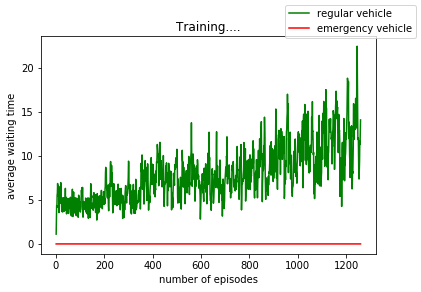

In [65]:
# vehicle average waiting time history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,regular_waiting_history,'average waiting time',color='green',label='regular vehicle')
plot(episode_count,emergency_waiting_history,'average waiting time',color='red',label='emergency vehicle')
fig.legend()

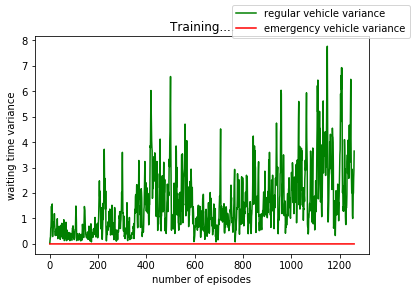

In [66]:
# vehicle waiting time variance history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,regular_var_history,'waiting time variance',color='green',label='regular vehicle variance')
plot(episode_count,emergency_var_history,'waiting time variance',color='red',label='emergency vehicle variance')
fig.legend()

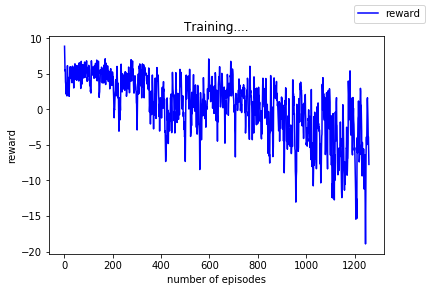

In [67]:
#reward history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,reward_history,'reward',color='blue',label='reward')
fig.legend()